This Jupyter Notebook comprises of the following:
1. Improved Dataset preparation for better hurricane path and intensity prediction
2. Model Implementation for three window sizes and result visualisation

SECTION 1: Preparing the better dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Final Datasets Hurricane Wise/Hurricane Ian for Model.xlsx')

In [3]:
df.head()

,ADVDATE,ADVISNUM,DATELBL,FLDATELBL,GUST,LAT,LON,MAXWIND,MSLP,SSNUM,TCDVLP,TAU,TCDIR,TCSPD,TIMEZONE,VALIDTIME
0,400 AM EDT Fri Sep 23 2022,1.0,5:00 AM Fri,2022-09-23 2:00 AM Fri AST,40,13.9,-68.6,30,1006,0,Tropical Depression,0,290,11,EDT,23/0600
1,400 AM EDT Fri Sep 23 2022,1.0,2:00 PM Fri,2022-09-23 2:00 PM Fri AST,45,14.4,-70.2,35,9999,0,Tropical Storm,12,9999,9999,EDT,23/1800
2,400 AM EDT Fri Sep 23 2022,1.0,2:00 AM Sat,2022-09-24 2:00 AM Sat AST,45,14.7,-72.6,35,9999,0,Tropical Storm,24,9999,9999,EDT,24/0600
3,400 AM EDT Fri Sep 23 2022,1.0,2:00 PM Sat,2022-09-24 2:00 PM Sat AST,45,14.8,-75.0,35,9999,0,Tropical Storm,36,9999,9999,EDT,24/1800
4,400 AM EDT Fri Sep 23 2022,1.0,2:00 AM Sun,2022-09-25 2:00 AM Sun AST,50,15.5,-77.1,40,9999,0,Tropical Storm,48,9999,9999,EDT,25/0600


In [49]:
import pandas as pd

# Function to calculate dW/dT, d2W/dT2, deltaLAT, and deltaLON
def calculate_deltas(group):
    # Sort by TAU to ensure the correct order
    group = group.sort_values(by='TAU')
    
    # Calculate dW/dT (rate of change of MAXWIND)
    dW_dT = (group['MAXWIND'].diff() / group['TAU'].diff()).mean()
    
    # Calculate d2W/dT2 (second derivative of MAXWIND)
    dW_dT_diff = (group['MAXWIND'].diff() / group['TAU'].diff()).diff()
    d2W_dT2 = (dW_dT_diff / group['TAU'].diff()).mean()
    
    # Calculate deltaLAT (change in latitude) and deltaLON (change in longitude)
    deltaLAT = (group['LAT'].diff() / group['TAU'].diff()).mean()
    deltaLON = (group['LON'].diff() / group['TAU'].diff()).mean()
    
    return dW_dT, d2W_dT2, deltaLAT, deltaLON

# Group by ADVISNUM to process each advisory separately
transformed_data = []
for advisnum, group in df.groupby('ADVISNUM'):
    # Get the first row's LAT, LON, MSLP, W (MAXWIND)
    first_row = group.iloc[0]
    
    # Calculate WMAX (maximum MAXWIND in the advisory)
    WMAX = group['MAXWIND'].max()
    
    # Calculate dW/dT, d2W/dT2, deltaLAT, and deltaLON
    dW_dT, d2W_dT2, deltaLAT, deltaLON = calculate_deltas(group)
    
    # Append the transformed row
    transformed_data.append({
        'ADVISNUM': advisnum,
        'LAT': first_row['LAT'],
        'LON': first_row['LON'],
        'MSLP': first_row['MSLP'],
        'W': first_row['MAXWIND'],
        'dW/dT': dW_dT,
        'd2W/dT2': d2W_dT2,
        'WMAX': WMAX,
        'deltaLAT': deltaLAT,
        'deltaLON': deltaLON,
        'Timestamp': first_row['ADVDATE']
    })

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data)

# Output the transformed DataFrame
transformed_df


,ADVISNUM,LAT,LON,MSLP,W,dW/dT,d2W/dT2,WMAX,deltaLAT,deltaLON,Timestamp
0,1.0,13.9,-68.6,1006,30,0.520833,0.001240,95,0.089062,-0.133333,400 AM EDT Fri Sep 23 2022
1,2.0,14.2,-70.1,1006,30,0.598958,0.004960,100,0.094271,-0.121354,1100 AM EDT Fri Sep 23 2022
2,3.0,14.7,-71.3,1006,30,0.625000,0.003720,100,0.095313,-0.116667,500 PM EDT Fri Sep 23 2022
3,3.5,14.8,-71.5,1006,30,0.625000,0.003720,100,0.094271,-0.114583,800 PM EDT Fri Sep 23 2022
4,4.0,14.8,-72.0,1005,35,0.598958,0.001240,100,0.102083,-0.106250,1100 PM EDT Fri Sep 23 2022
...,...,...,...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,998,35,-0.625000,-0.034722,35,0.108333,0.020833,200 AM EDT Sat Oct 01 2022
64,35.0,35.7,-79.8,1001,30,-0.416667,NaN,30,0.091667,0.016667,500 AM EDT Sat Oct 01 2022
65,36.0,36.4,-79.9,1006,20,-0.208333,-0.034722,20,0.012500,0.075000,1100 AM EDT Sat Oct 01 2022
66,37.0,36.8,-78.8,1008,20,0.000000,NaN,20,0.033333,0.050000,500 PM EDT Sat Oct 01 2022


In [50]:
import pandas as pd

# Ensure ADVDATE is in datetime format
transformed_df['Timestamp'] = pd.to_datetime(transformed_df['Timestamp'], format='%I%M %p EDT %a %b %d %Y')

# Sort the dataframe by ADVISNUM and ADVDATE to ensure correct time order
transformed_df = transformed_df.sort_values(by=['ADVISNUM', 'Timestamp'])

# Display the updated dataframe with the Timestamp column
transformed_df[['ADVISNUM', 'Timestamp']]

,ADVISNUM,Timestamp
0,1.0,2022-09-23 04:00:00
1,2.0,2022-09-23 11:00:00
2,3.0,2022-09-23 17:00:00
3,3.5,2022-09-23 20:00:00
4,4.0,2022-09-23 23:00:00
...,...,...
63,34.5,2022-10-01 02:00:00
64,35.0,2022-10-01 05:00:00
65,36.0,2022-10-01 11:00:00
66,37.0,2022-10-01 17:00:00


In [51]:
# CONVERTING TIMESTAMP TO TIMEELAPSED
start_time = transformed_df['Timestamp'].iloc[0]
time_elapsed = []
# Loop through each row and calculate the time difference in hours
for Timestamp in transformed_df['Timestamp']:
    elapsed = (Timestamp - start_time).total_seconds() / 3600  # Convert seconds to hours
    time_elapsed.append(elapsed)

# Add the TimeElapsed column to the DataFrame
transformed_df['TimeElapsed'] = time_elapsed
transformed_df

,ADVISNUM,LAT,LON,MSLP,W,dW/dT,d2W/dT2,WMAX,deltaLAT,deltaLON,Timestamp,TimeElapsed
0,1.0,13.9,-68.6,1006,30,0.520833,0.001240,95,0.089062,-0.133333,2022-09-23 04:00:00,0.0
1,2.0,14.2,-70.1,1006,30,0.598958,0.004960,100,0.094271,-0.121354,2022-09-23 11:00:00,7.0
2,3.0,14.7,-71.3,1006,30,0.625000,0.003720,100,0.095313,-0.116667,2022-09-23 17:00:00,13.0
3,3.5,14.8,-71.5,1006,30,0.625000,0.003720,100,0.094271,-0.114583,2022-09-23 20:00:00,16.0
4,4.0,14.8,-72.0,1005,35,0.598958,0.001240,100,0.102083,-0.106250,2022-09-23 23:00:00,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,998,35,-0.625000,-0.034722,35,0.108333,0.020833,2022-10-01 02:00:00,190.0
64,35.0,35.7,-79.8,1001,30,-0.416667,NaN,30,0.091667,0.016667,2022-10-01 05:00:00,193.0
65,36.0,36.4,-79.9,1006,20,-0.208333,-0.034722,20,0.012500,0.075000,2022-10-01 11:00:00,199.0
66,37.0,36.8,-78.8,1008,20,0.000000,NaN,20,0.033333,0.050000,2022-10-01 17:00:00,205.0


In [52]:
df_final = transformed_df[['ADVISNUM','LAT','LON', 'deltaLAT', 'deltaLON', 'MSLP','W','dW/dT','WMAX','TimeElapsed']]
df_final

,ADVISNUM,LAT,LON,deltaLAT,deltaLON,MSLP,W,dW/dT,WMAX,TimeElapsed
0,1.0,13.9,-68.6,0.089062,-0.133333,1006,30,0.520833,95,0.0
1,2.0,14.2,-70.1,0.094271,-0.121354,1006,30,0.598958,100,7.0
2,3.0,14.7,-71.3,0.095313,-0.116667,1006,30,0.625000,100,13.0
3,3.5,14.8,-71.5,0.094271,-0.114583,1006,30,0.625000,100,16.0
4,4.0,14.8,-72.0,0.102083,-0.106250,1005,35,0.598958,100,19.0
...,...,...,...,...,...,...,...,...,...,...
63,34.5,35.4,-79.7,0.108333,0.020833,998,35,-0.625000,35,190.0
64,35.0,35.7,-79.8,0.091667,0.016667,1001,30,-0.416667,30,193.0
65,36.0,36.4,-79.9,0.012500,0.075000,1006,20,-0.208333,20,199.0
66,37.0,36.8,-78.8,0.033333,0.050000,1008,20,0.000000,20,205.0


SECTION 2: Model Implementation Begins

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [22]:
# Select features to use
features = ['LAT', 'LON', 'deltaLAT', 'deltaLON', 'MSLP', 'W', 'dW/dT', 'WMAX', 'TimeElapsed']
df_final = df_final[features]

In [23]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_final)

SECTION 2 (i): Sliding Window of (3,1) - Using three previous advisories to predict next one

In [24]:
# Prepare data for sliding window approach
def create_dataset(data, time_step=3):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])  # Predicting the entire row for the next time step
    return np.array(X), np.array(y)

time_step = 3
X, y = create_dataset(data_scaled, time_step)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features)))  # Output layer should match number of features (7)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to get the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

Epoch 1/500


C:\Users\Mridul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.3441 - val_loss: 0.3528
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2862 - val_loss: 0.3069
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2335 - val_loss: 0.2649
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1928 - val_loss: 0.2284
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1508 - val_loss: 0.1948
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1143 - val_loss: 0.1693
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0813 - val_loss: 0.1511
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0608 - val_loss: 0.1432
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0447 - val_loss: 0.1448
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0360 - val_loss: 0.1494
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - val_loss: 0.1459
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0335 - val_loss: 0.1374
Epo

Looking at the Mean Absolute Error for each feature

In [25]:
# Calculate and print the error for each feature
error = np.abs(y_pred_rescaled - y_test_rescaled)
for i, feature in enumerate(features):
    print(f'Mean Absolute Error for {feature}: {np.mean(error[:, i])}')

Mean Absolute Error for LAT: 1.4213334303635814
Mean Absolute Error for LON: 0.6779948307917661
Mean Absolute Error for deltaLAT: 0.04789166121910775
Mean Absolute Error for deltaLON: 0.04732960927435477
Mean Absolute Error for MSLP: 7.224219689002395
Mean Absolute Error for W: 13.496373396653395
Mean Absolute Error for dW/dT: 0.49559488357641757
Mean Absolute Error for WMAX: 7.519734309269832
Mean Absolute Error for TimeElapsed: 4.9134603647085315


Looking at the correlation heatmap of features to verify if feature engineering is helpful

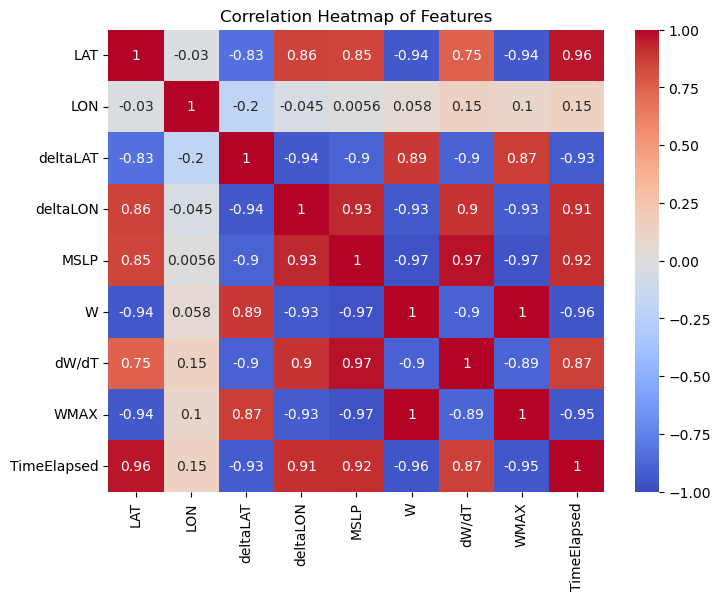

In [26]:
import seaborn as sns
corr_matrix = pd.DataFrame(y_test_rescaled, columns=features).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Features')
plt.show()

We can clearly see that for WMAX, almost all features hold a good relation

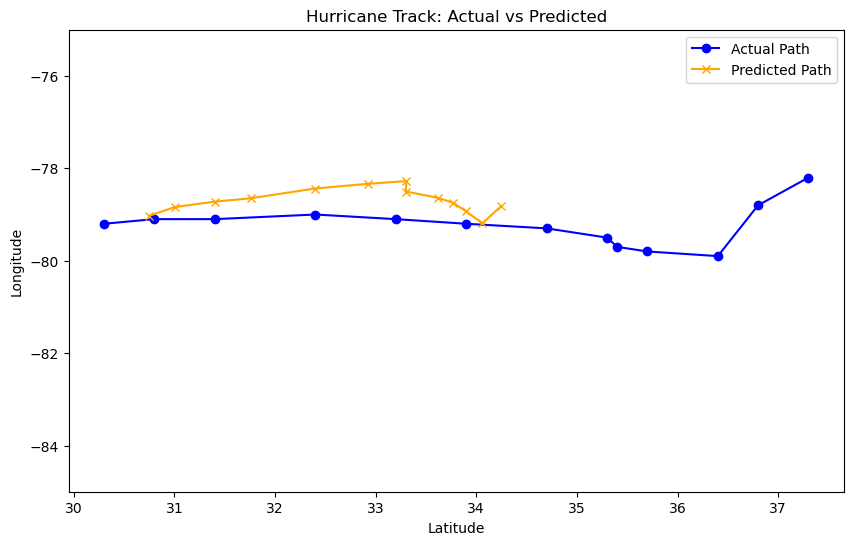

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:, 0], y_test_rescaled[:, 1], label='Actual Path', marker='o', color='blue')
plt.plot(y_pred_rescaled[:, 0], y_pred_rescaled[:, 1], label='Predicted Path', marker='x', color='orange')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hurricane Track: Actual vs Predicted')
plt.ylim(-85,-75)
plt.legend()
plt.show()

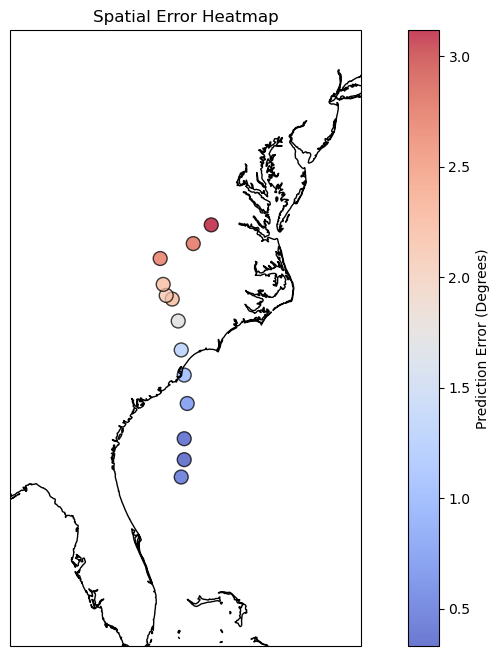

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

sc = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc, label='Prediction Error (Degrees)')
plt.title('Spatial Error Heatmap')
plt.show()


Plotting the Actual vs Predicted paths on a map, where the actual path is colored by error

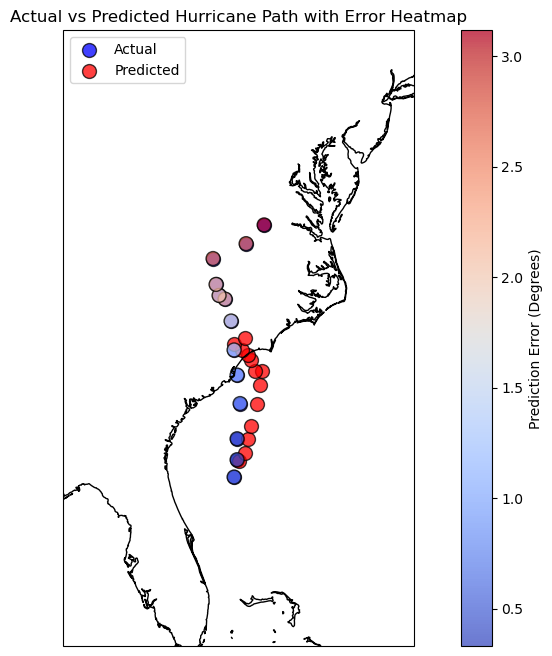

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns for both actual and predicted data
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

# Scatter plot for actual points
sc_actual = ax.scatter(lon_actual, lat_actual, c='blue', label='Actual', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Scatter plot for predicted points
sc_pred = ax.scatter(lon_pred, lat_pred, c='red', label='Predicted', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Add colorbar for error magnitude
sc_error = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc_error, label='Prediction Error (Degrees)')

# Add a legend
plt.legend(loc='upper left')

plt.title('Actual vs Predicted Hurricane Path with Error Heatmap')
plt.show()


Creating an intensity classification function to understand how intensity predictions are performing

In [40]:
def classify_intensity_knots(WMAX, MSLP, dW_dT):
    if WMAX >= 96 or (MSLP < 945 and dW_dT > 2.5):  # Major Hurricane conditions
        return 'Major Hurricane'
    elif WMAX >= 64 or (MSLP < 980 and dW_dT > 1.5):  # Hurricane conditions
        return 'Hurricane'
    elif WMAX >= 34:  # Tropical Storm threshold
        return 'Tropical Storm'
    else:
        return 'Tropical Depression'


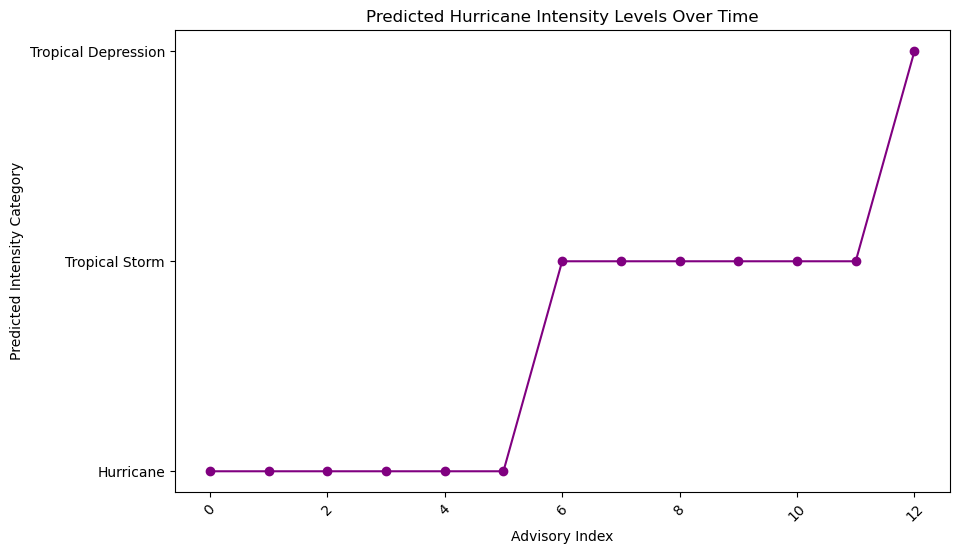

In [41]:
intensity_levels = [classify_intensity_knots(wmax, mslp, dwdt) 
                    for wmax, mslp, dwdt in zip(y_pred_rescaled[:, features.index('WMAX')], 
                                                y_pred_rescaled[:, features.index('MSLP')],
                                                y_pred_rescaled[:, features.index('dW/dT')])]

plt.figure(figsize=(10, 6))
plt.plot(range(len(intensity_levels)), intensity_levels, marker='o', linestyle='-', color='purple')
plt.xticks(rotation=45)
plt.xlabel("Advisory Index")
plt.ylabel("Predicted Intensity Category")
plt.title("Predicted Hurricane Intensity Levels Over Time")
plt.show()


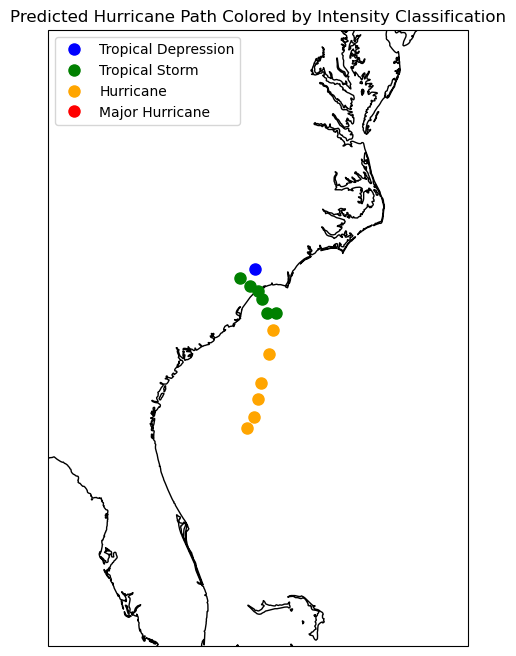

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.colors as mcolors

# Convert intensity levels to color codes
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Map each advisory to a color based on intensity classification
colors = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_pred) - 5, max(lon_pred) + 5, min(lat_pred) - 5, max(lat_pred) + 5])

# Plot the predicted path, coloring points by intensity classification
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='o', color=colors[i], markersize=8,
            transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
plt.legend(handles=handles, loc='upper left')

plt.title("Predicted Hurricane Path Colored by Intensity Classification")
plt.show()


Intensity as well as path plotted on a map for Actual vs Prediction data

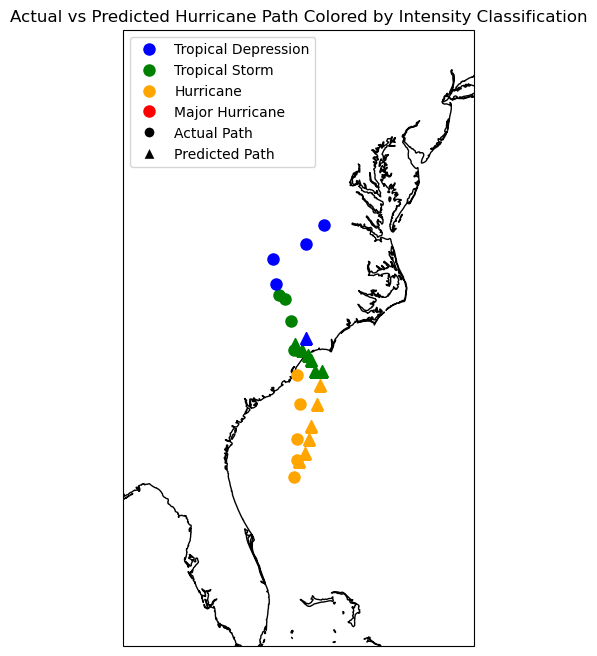

In [43]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming the classify_intensity_knots function is already defined

# Calculate intensity classifications for actual data
intensity_levels_actual = [classify_intensity_knots(wmax, mslp, dwdt) 
                           for wmax, mslp, dwdt in zip(y_test_rescaled[:, features.index('WMAX')], 
                                                       y_test_rescaled[:, features.index('MSLP')],
                                                       y_test_rescaled[:, features.index('dW/dT')])]

# Map intensity levels to colors for both predicted and actual data
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Color lists for actual and predicted paths
colors_actual = [intensity_colors[level] for level in intensity_levels_actual]
colors_predicted = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(min(lon_actual), min(lon_pred)) - 5, max(max(lon_actual), max(lon_pred)) + 5, 
               min(min(lat_actual), min(lat_pred)) - 5, max(max(lat_actual), max(lat_pred)) + 5])

# Plot actual path with colors for intensity
for i in range(len(lon_actual)):
    ax.plot(lon_actual[i], lat_actual[i], marker='o', color=colors_actual[i], markersize=8, 
            label='Actual' if i == 0 else "", transform=ccrs.PlateCarree())

# Plot predicted path with colors for intensity
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='^', color=colors_predicted[i], markersize=8, 
            label='Predicted' if i == 0 else "", transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label="Actual Path", markerfacecolor='k', markersize=8))
handles.append(plt.Line2D([0], [0], marker='^', color='w', label="Predicted Path", markerfacecolor='k', markersize=8))
plt.legend(handles=handles, loc='upper left')

plt.title("Actual vs Predicted Hurricane Path Colored by Intensity Classification")
plt.show()


SECTION 2 (ii): Sliding Window of (5,1) - Using five previous advisories to predict next one. Repeating the entire above process.

In [56]:
# Prepare data for sliding window approach
def create_dataset(data, time_step=3):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])  # Predicting the entire row for the next time step
    return np.array(X), np.array(y)

time_step = 5
X, y = create_dataset(data_scaled, time_step)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features)))  # Output layer should match number of features (7)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to get the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

C:\Users\Mridul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3483 - val_loss: 0.2485
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2041 - val_loss: 0.1456
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1100 - val_loss: 0.0998
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0638 - val_loss: 0.1136
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0434 - val_loss: 0.1522
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0423 - val_loss: 0.1733
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375 - val_loss: 0.1645
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0307 - val_loss: 0.1376
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0208 - val_loss: 0.1128
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184 - val_loss: 0.0956
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - val_loss: 0.0919
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0138 - val_loss: 0.0951


In [57]:
# Calculate and print the error for each feature
error = np.abs(y_pred_rescaled - y_test_rescaled)
for i, feature in enumerate(features):
    print(f'Mean Absolute Error for {feature}: {np.mean(error[:, i])}')

Mean Absolute Error for LAT: 1.2569057464599604
Mean Absolute Error for LON: 1.0878917987530037
Mean Absolute Error for deltaLAT: 0.05457072207051458
Mean Absolute Error for deltaLON: 0.06486082771140288
Mean Absolute Error for MSLP: 4.046475923978357
Mean Absolute Error for W: 11.777514237623949
Mean Absolute Error for dW/dT: 0.4480558190590296
Mean Absolute Error for WMAX: 5.185436542217548
Mean Absolute Error for TimeElapsed: 3.7640932523287236


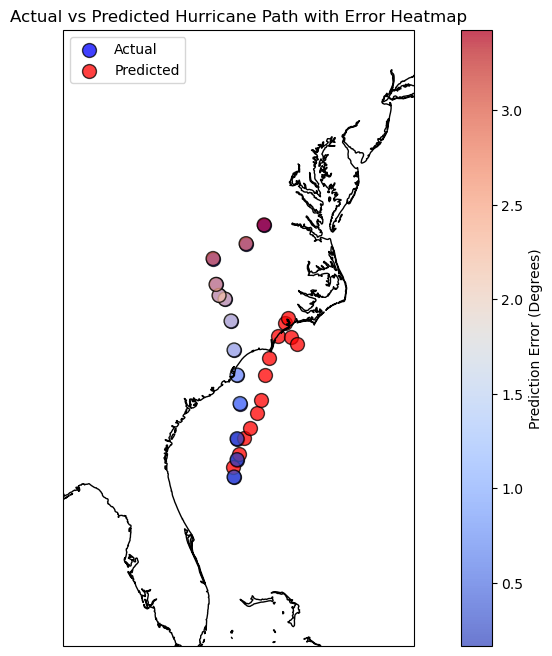

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns for both actual and predicted data
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

# Scatter plot for actual points
sc_actual = ax.scatter(lon_actual, lat_actual, c='blue', label='Actual', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Scatter plot for predicted points
sc_pred = ax.scatter(lon_pred, lat_pred, c='red', label='Predicted', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Add colorbar for error magnitude
sc_error = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc_error, label='Prediction Error (Degrees)')

# Add a legend
plt.legend(loc='upper left')

plt.title('Actual vs Predicted Hurricane Path with Error Heatmap')
plt.show()


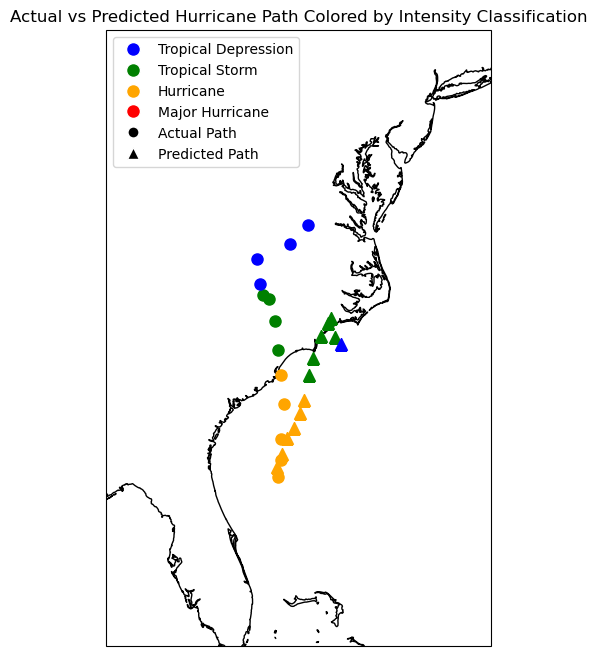

In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming the classify_intensity_knots function is already defined

# Calculate intensity classifications for actual data
intensity_levels_actual = [classify_intensity_knots(wmax, mslp, dwdt) 
                           for wmax, mslp, dwdt in zip(y_test_rescaled[:, features.index('WMAX')], 
                                                       y_test_rescaled[:, features.index('MSLP')],
                                                       y_test_rescaled[:, features.index('dW/dT')])]

# Map intensity levels to colors for both predicted and actual data
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Color lists for actual and predicted paths
colors_actual = [intensity_colors[level] for level in intensity_levels_actual]
colors_predicted = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(min(lon_actual), min(lon_pred)) - 5, max(max(lon_actual), max(lon_pred)) + 5, 
               min(min(lat_actual), min(lat_pred)) - 5, max(max(lat_actual), max(lat_pred)) + 5])

# Plot actual path with colors for intensity
for i in range(len(lon_actual)):
    ax.plot(lon_actual[i], lat_actual[i], marker='o', color=colors_actual[i], markersize=8, 
            label='Actual' if i == 0 else "", transform=ccrs.PlateCarree())

# Plot predicted path with colors for intensity
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='^', color=colors_predicted[i], markersize=8, 
            label='Predicted' if i == 0 else "", transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label="Actual Path", markerfacecolor='k', markersize=8))
handles.append(plt.Line2D([0], [0], marker='^', color='w', label="Predicted Path", markerfacecolor='k', markersize=8))
plt.legend(handles=handles, loc='upper left')

plt.title("Actual vs Predicted Hurricane Path Colored by Intensity Classification")
plt.show()

SECTION 2 (iii): Sliding Window of (7,1) - Using five previous advisories to predict next one. Repeating the entire above process.

In [60]:
# Prepare data for sliding window approach
def create_dataset(data, time_step=3):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])  # Predicting the entire row for the next time step
    return np.array(X), np.array(y)

time_step = 7
X, y = create_dataset(data_scaled, time_step)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(features)))  # Output layer should match number of features (7)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to get the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

Epoch 1/500


C:\Users\Mridul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.3215 - val_loss: 0.3392
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1999 - val_loss: 0.2541
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1032 - val_loss: 0.1899
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0496 - val_loss: 0.1626
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0374 - val_loss: 0.1609
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0480 - val_loss: 0.1382
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0334 - val_loss: 0.1221
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0203 - val_loss: 0.1219
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188 - val_loss: 0.1264
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178 - val_loss: 0.1277
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.1216
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183 - val_loss: 0.1107


In [61]:
# Calculate and print the error for each feature
error = np.abs(y_pred_rescaled - y_test_rescaled)
for i, feature in enumerate(features):
    print(f'Mean Absolute Error for {feature}: {np.mean(error[:, i])}')

Mean Absolute Error for LAT: 1.6971626281738277
Mean Absolute Error for LON: 1.196639310396634
Mean Absolute Error for deltaLAT: 0.04892560169737558
Mean Absolute Error for deltaLON: 0.05084901252108763
Mean Absolute Error for MSLP: 5.144000713641818
Mean Absolute Error for W: 22.33886249248798
Mean Absolute Error for dW/dT: 0.625739791454413
Mean Absolute Error for WMAX: 12.06975951561561
Mean Absolute Error for TimeElapsed: 5.365001971905046


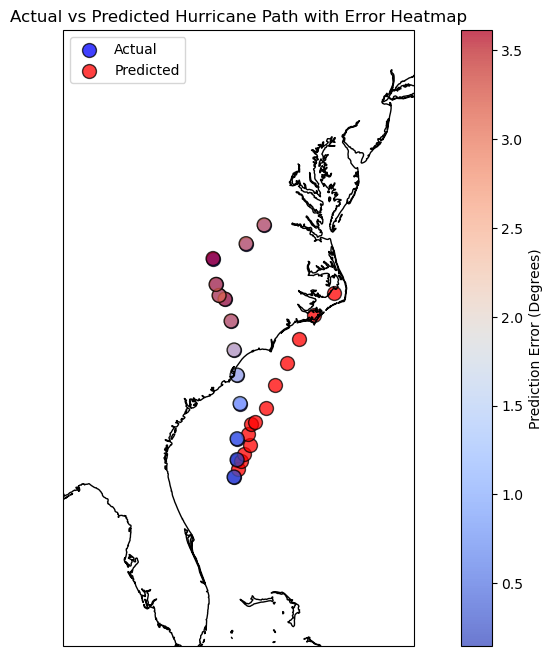

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming LAT, LON are in the first two columns for both actual and predicted data
lat_actual = y_test_rescaled[:, 0]
lon_actual = y_test_rescaled[:, 1]
lat_pred = y_pred_rescaled[:, 0]
lon_pred = y_pred_rescaled[:, 1]

error = np.sqrt((lat_actual - lat_pred) ** 2 + (lon_actual - lon_pred) ** 2)

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(lon_actual) - 5, max(lon_actual) + 5, min(lat_actual) - 5, max(lat_actual) + 5])

# Scatter plot for actual points
sc_actual = ax.scatter(lon_actual, lat_actual, c='blue', label='Actual', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Scatter plot for predicted points
sc_pred = ax.scatter(lon_pred, lat_pred, c='red', label='Predicted', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())

# Add colorbar for error magnitude
sc_error = ax.scatter(lon_actual, lat_actual, c=error, cmap='coolwarm', s=100, edgecolor='k', alpha=0.75, transform=ccrs.PlateCarree())
plt.colorbar(sc_error, label='Prediction Error (Degrees)')

# Add a legend
plt.legend(loc='upper left')

plt.title('Actual vs Predicted Hurricane Path with Error Heatmap')
plt.show()


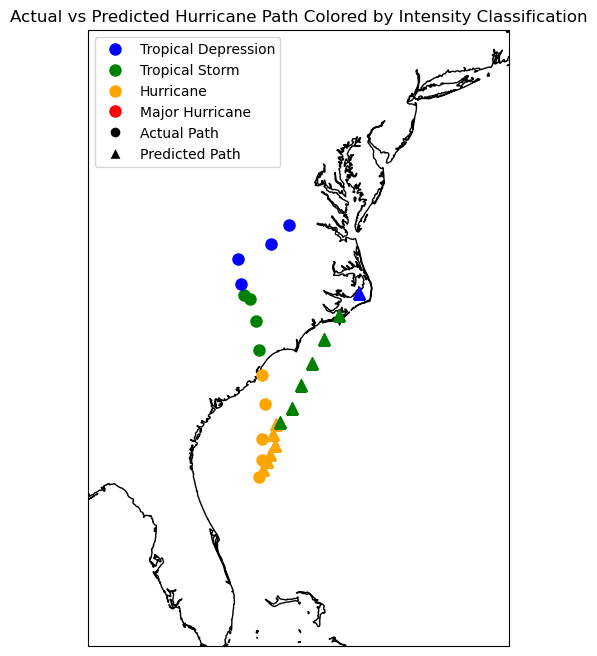

In [63]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming the classify_intensity_knots function is already defined

# Calculate intensity classifications for actual data
intensity_levels_actual = [classify_intensity_knots(wmax, mslp, dwdt) 
                           for wmax, mslp, dwdt in zip(y_test_rescaled[:, features.index('WMAX')], 
                                                       y_test_rescaled[:, features.index('MSLP')],
                                                       y_test_rescaled[:, features.index('dW/dT')])]

# Map intensity levels to colors for both predicted and actual data
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Color lists for actual and predicted paths
colors_actual = [intensity_colors[level] for level in intensity_levels_actual]
colors_predicted = [intensity_colors[level] for level in intensity_levels]

# Create the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(min(lon_actual), min(lon_pred)) - 5, max(max(lon_actual), max(lon_pred)) + 5, 
               min(min(lat_actual), min(lat_pred)) - 5, max(max(lat_actual), max(lat_pred)) + 5])

# Plot actual path with colors for intensity
for i in range(len(lon_actual)):
    ax.plot(lon_actual[i], lat_actual[i], marker='o', color=colors_actual[i], markersize=8, 
            label='Actual' if i == 0 else "", transform=ccrs.PlateCarree())

# Plot predicted path with colors for intensity
for i in range(len(lon_pred)):
    ax.plot(lon_pred[i], lat_pred[i], marker='^', color=colors_predicted[i], markersize=8, 
            label='Predicted' if i == 0 else "", transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
handles.append(plt.Line2D([0], [0], marker='o', color='w', label="Actual Path", markerfacecolor='k', markersize=8))
handles.append(plt.Line2D([0], [0], marker='^', color='w', label="Predicted Path", markerfacecolor='k', markersize=8))
plt.legend(handles=handles, loc='upper left')

plt.title("Actual vs Predicted Hurricane Path Colored by Intensity Classification")
plt.show()

Thus we have concluded the model predictions for the three window sizes. 
The map that is generated below just shows how the intensity varies for the entire ACTUAL data of Hurricane Ian based on our classifier.

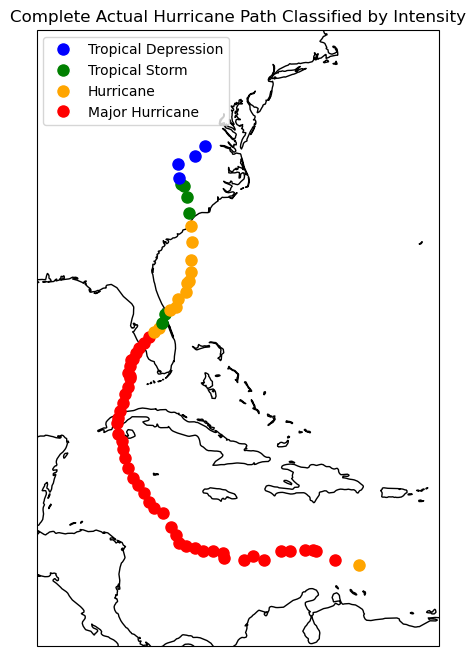

In [48]:
# Accessing actual latitude and longitude from full data
full_lat_actual = df_final['LAT'].values
full_lon_actual = df_final['LON'].values

# Classify intensity for the full dataset
intensity_levels_full = [classify_intensity_knots(wmax, mslp, dwdt) 
                         for wmax, mslp, dwdt in zip(df_final['WMAX'], 
                                                     df_final['MSLP'],
                                                     df_final['dW/dT'])]

# Map intensity levels to colors
intensity_colors = {
    'Tropical Depression': 'blue',
    'Tropical Storm': 'green',
    'Hurricane': 'orange',
    'Major Hurricane': 'red'
}

# Generate color list for the entire actual path
colors_full = [intensity_colors[level] for level in intensity_levels_full]

# Plotting the full path on the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.set_extent([min(full_lon_actual) - 5, max(full_lon_actual) + 5, 
               min(full_lat_actual) - 5, max(full_lat_actual) + 5])

# Plot each point along the path, color-coded by intensity
for i in range(len(full_lon_actual)):
    ax.plot(full_lon_actual[i], full_lat_actual[i], marker='o', color=colors_full[i], markersize=8, 
            transform=ccrs.PlateCarree())

# Add a custom legend for intensity levels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                      markerfacecolor=color, markersize=10) for key, color in intensity_colors.items()]
plt.legend(handles=handles, loc='upper left')

plt.title("Complete Actual Hurricane Path Classified by Intensity")
plt.show()


On comparing the above map with damage reports, we observe a very high correlation of intensity and devastation.
This step was necessary to check whether our intensity classifier is trustworthy or not.